In [2]:
%load_ext nb_black
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
from typing import Tuple, Union, Dict, List

<IPython.core.display.Javascript object>

In [69]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [102]:
class DecisionNode:
    def __init__(self, question, true_node, false_node):
        self.question = question
        self.true_node = true_node
        self.false_node = false_node


class Leaf:
    """Just want the class probabilities"""

    def __init__(self, rows):
        self.mean = self.find_leaf_mean(rows)

    def find_leaf_mean(self, rows: pd.DataFrame) -> Dict:
        return np.mean(rows["label"])

    def __repr__(self) -> str:
        return str(self.mean)


class Question:
    def __init__(self, feature: str, value: Union[str, float, int]):
        self.feature = feature
        self.value = value
        self.is_numeric_feature = self.is_numeric(value)

    @staticmethod
    def is_numeric(value):
        """Test if a value is numeric."""
        return isinstance(value, int) or isinstance(value, float)

    def ask(self, rows: pd.DataFrame) -> pd.Series:
        if self.is_numeric_feature:
            answer = rows[self.feature] >= self.value
        else:
            answer = rows[self.feature] == self.value

        return answer

    def __repr__(self) -> str:
        if self.is_numeric_feature:
            return f"Is {self.feature} >= {self.value}?"
        else:
            return f"Is {self.feature} == {self.value}?"


# At every node I want to find the best question
class RegressionTree:
    def __init__(self, features):
        self.features = features

    @staticmethod
    def gini(rows: pd.DataFrame) -> pd.DataFrame:
        n = len(rows)
        clas_prob = rows.groupby("label").agg(**{"prob": ("label", "count")}) / n
        return 1 - np.sum(clas_prob["prob"] ** 2)

    @staticmethod
    def variance(rows: pd.DataFrame) -> pd.DataFrame:
        return np.var(rows["label"])

    def weighted_average_gini(self, true_values, false_values):
        n_true = len(true_values)
        n_false = len(false_values)
        n = n_true + n_false
        weighted_gini = (n_true / n) * self.gini(true_values) + (
            n_false / n
        ) * self.gini(false_values)
        return weighted_gini

    def weighted_average_variance(self, true_values, false_values):
        n_true = len(true_values)
        n_false = len(false_values)
        n = n_true + n_false
        weighted_var = (n_true / n) * self.variance(true_values) + (
            n_false / n
        ) * self.variance(false_values)
        return weighted_var

    def find_unique_values(self, series: pd.Series) -> List:
        return series.drop_duplicates().to_list()

    def find_best_question(self, rows: pd.DataFrame) -> Tuple[Question, float]:
        # For a data set, what is the bets question I can ask to split the data
        # for every feature I want to create a bunch of questions
        # I want to find the question which reduces the gini the most
        # #
        variance_before_split = self.variance(rows)

        best_question = None
        best_gain = 0

        for feat in self.features:
            possible_vals = self.find_unique_values(rows[feat])
            for val in possible_vals:
                q = Question(feature=feat, value=val)
                is_cond_true = q.ask(rows=rows)
                true_rows, false_rows = rows[is_cond_true], rows[~is_cond_true]
                # get weighted average gini
                variance_after_split = self.weighted_average_variance(
                    true_rows, false_rows
                )
                # find the information gain from asking the question
                info_gain = variance_before_split - variance_after_split
                if (
                    (info_gain >= best_gain)
                    & (len(true_rows) > 2)
                    & (len(false_rows) > 2)
                ):
                    best_question = q
                    best_gain = info_gain

        return best_question, best_gain

    def split(
        self, rows: pd.DataFrame, question: Question
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Return the data for the left and right nodes """

        is_cond_true = question.ask(rows=rows)
        true_rows, false_rows = rows[is_cond_true], rows[~is_cond_true]

        return true_rows, false_rows

    def build_tree(self, rows: pd.DataFrame) -> DecisionNode:
        question_, gain_ = self.find_best_question(rows)

        if gain_ == 0:
            return Leaf(rows=rows)

        true_rows, false_rows = self.split(rows=rows, question=question_)

        return DecisionNode(
            question=question_,
            true_node=self.build_tree(true_rows),
            false_node=self.build_tree(false_rows),
        )

    def fit(rows: pd.DataFrame) -> None:
        pass


def print_tree(node: Union[DecisionNode, Leaf], level=0) -> None:
    prefix = " " * 2 ** level + "|__" if level > 0 else ""

    if isinstance(node, Leaf):
        print(prefix, node)
        return

    print(prefix, node.question)

    print_tree(node.true_node, level=level + 1)
    print_tree(node.false_node, level=level + 1)


def predict(node, row: pd.DataFrame, level=0):
    prefix = " " * 2 ** level + "|__" if level > 0 else ""

    if isinstance(node, Leaf):
        return node.mean
    is_cond_true = node.question.ask(row)

    if is_cond_true.values[0]:
        return predict(node=node.true_node, row=row)
    else:
        return predict(node=node.false_node, row=row)

<IPython.core.display.Javascript object>

In [63]:
training_data = pd.DataFrame(
    [[-50, 1], [20, 2], [20, 2.5], [20, 2], [-50, 1.5],], columns=["color", "label"],
)

training_data

,color,label
0,-50,1.0
1,20,2.0
2,20,2.5
3,20,2.0
4,-50,1.5


<IPython.core.display.Javascript object>

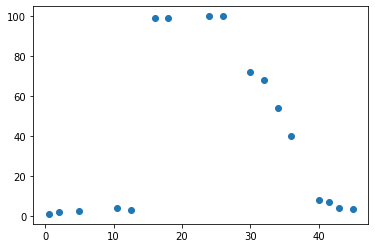

<IPython.core.display.Javascript object>

In [103]:
training_data = pd.DataFrame(
    [
        # Regime 1
        [0.5, 1],
        [2, 2],
        [5, 2.5],
        [10.5, 4],
        [12.5, 3],
        # Regime 2
        [16, 99.0],
        [18, 99.0],
        [24, 100.0],
        [26.0, 100.0],
        # Regime 3
        [30, 72.0],
        [32, 68.0],
        [34, 54],
        [36.0, 40.0],
        # Regime 4
        [40.0, 8.0],
        [41.5, 7],
        [43, 4],
        [45.0, 3.2],
    ],
    columns=["dosage", "label"],
)

plt.scatter(x=training_data["dosage"], y=training_data["label"])

In [104]:
mod = RegressionTree(features=["dosage"])
tree = mod.build_tree(training_data)
print_tree(tree)

 Is dosage >= 16.0?
  |__ Is dosage >= 36.0?
    |__ 12.440000000000001
    |__ Is dosage >= 30.0?
        |__ 64.66666666666667
        |__ 99.5
  |__ 2.5


<IPython.core.display.Javascript object>

In [106]:
testing_data = pd.DataFrame(np.linspace(start=1, stop=45, num=40), columns=["dosage"])

<IPython.core.display.Javascript object>

In [107]:
preds = []
for i in range(len(testing_data)):
    preds.append(predict(tree, testing_data[i : i + 1]))

<IPython.core.display.Javascript object>

In [108]:
testing_data = testing_data.assign(**{"pred": preds})

<IPython.core.display.Javascript object>

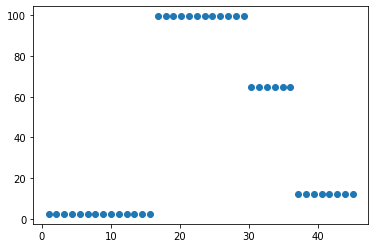

<IPython.core.display.Javascript object>

In [109]:
plt.scatter(x=testing_data["dosage"], y=testing_data["pred"])